In [5]:
#方法1：用beautifulsoup 进入首页，并爬取各个岗位具体网址中的信息
import requests
import re
from bs4 import BeautifulSoup
import json
import csv
import pandas as pd 
headers = {"user-agent":"Mozilla/5.0"}
#由于实习僧对应数字有反爬机制，故需要提前设置字典，将编码转换为数字
def hack_number(text):
    #通过观察实习僧网页中的数字，得出下面数字的编码
    text = text.encode('utf-8')
    text = text.replace(b'\xef\x82\x9d', b'0')
    text = text.replace(b'\xee\xa6\x88', b'1')
    text = text.replace(b'\xee\xa8\xb4', b'2')
    text = text.replace(b'\xef\x91\xbe', b'3')
    text = text.replace(b'\xee\x88\x9d', b'4')
    text = text.replace(b'\xef\x97\x80', b'5')
    text = text.replace(b'\xee\x85\x9f', b'6')
    text = text.replace(b'\xee\x98\x92', b'7')
    text = text.replace(b'\xef\x80\x95', b'8')
    text = text.replace(b'\xef\x94\x9b', b'9')
    text = text.decode()

    return text

def detail_page(url):
    global name
    global minmoney
    global maxmoney
    global position
    global academic
    global week 
    global time
    global guanjianzi
    

    req = requests.get(url,headers=headers)
    html = req.text
    soup = BeautifulSoup(html,'lxml')
    #爬取职位名称
    job_name = soup.select('.new_job_name')[0].text.strip()
    #爬取职位工资
    job_money = hack_number(soup.select('.job_money')[0].text.strip())
    #爬取工作地点
    job_position = soup.select('.job_position')[0].text.strip()
    #爬取工作要求学历
    job_academic = soup.select('.job_academic')[0].text.strip()
    #爬取工作职责等具体要求
    job_detail = soup.select('.job_detail')[0].text.strip().replace(' ','').replace('\n','')
    #爬取工作时长（单位：天/周）
    job_week = hack_number(soup.select('.job_week')[0].text.strip())
    #爬取工作时长（单位：月）
    job_time = hack_number(soup.select('.job_time')[0].text.strip())
    #爬取工作关键字
    job_good_list = soup.select('.job_good_list')
    #print(job_name,job_money,job_position,job_detail,job_week,job_time,job_good_list)
    #进行数据预处理
    job = {}    
    job['href'] = url
    job['new_job_name'] = job_name
    job['job_minmoney'] = re.sub(u"([^\u0030-\u0039])", "", job_money)[0:3]
    job['job_maxmoney'] = re.sub(u"([^\u0030-\u0039])", "", job_money)[3:]
    job['job_position'] = job_position
    job['job_academic'] = job_academic
    job['job_detail'] = job_detail
    job['job_week'] = re.sub(u"([^\u0030-\u0039])", "", job_week)
    job['job_time'] = re.sub(u"([^\u0030-\u0039])", "", job_time)
    job_guanjianzi = re.sub('[^\u4e00-\u9fa5]+', ' ',str(job_good_list))
    job_guanjianzi.strip('')
    a = job_guanjianzi.split(' ')
    a.remove('')
    a.remove('')
    job['job_guanjianzi'] = a
    #print(job)
    print('ok')
    #将数据储存在json文件中
    file = open('job.json','a',encoding='utf-8')
    file.write(json.dumps(job, indent=2,ensure_ascii=False))  #输入爬取的数据
        
    name.append(job_name)
    minmoney.append(re.sub(u"([^\u0030-\u0039])", "", job_money)[0:3])
    maxmoney.append(re.sub(u"([^\u0030-\u0039])", "", job_money)[3:])
    

    position.append(job_position) 
    academic.append(job_academic)
    week.append(re.sub(u"([^\u0030-\u0039])", "", job_week))  
    time.append(re.sub(u"([^\u0030-\u0039])", "", job_time))   
    guanjianzi.append(a)

name = []
minmoney = []
maxmoney = []
position = []
academic = []
week = []
time = []
guanjianzi = []
name.append('name')
minmoney.append('minmoney')
maxmoney.append('maxmoney')
position.append('job_position') 
academic.append('学历')
week.append('job_week')  
time.append('job_time')   
guanjianzi.append('关键字')

for pages in range(1,11):
    #首页，搜索词为“信息管理与信息系统”
    url = f'https://www.shixiseng.com/interns?page={pages}&type=intern&keyword=%E4%BF%A1%E6%81%AF%E7%AE%A1%E7%90%86%E4%B8%8E%E4%BF%A1%E6%81%AF%E7%B3%BB%E7%BB%9F&area=&months=&days=&degree=&official=&enterprise=&salary=-0&publishTime=&sortType=&city=%E5%85%A8%E5%9B%BD&internExtend='
    req = requests.get(url,headers=headers)
    html = req.text
    soup = BeautifulSoup(html,'lxml')
    detailurl=[]
    #提取每个职位的具体网址，格式为：https://www.shixiseng.com/intern/......?pcm=pc_SearchList
    for i in soup.select('a.title'):
        a=i.get('href')
        detailurl.append(a)   
    for detail_url in detailurl[::2]:
        detail_page(detail_url)
for i in minmoney[1:]:
    try:
        if int(i) > 500:
            minmoney.remove(i)
    except:
        continue
print(name,minmoney,maxmoney,position,academic,week,time,guanjianzi)
rows = zip(name,minmoney,maxmoney,position,academic,week,time,guanjianzi)
# 数据再储存在csv文件中
csvFile = open('job.csv','wt+',encoding='utf-8',newline='')
writer = csv.writer(csvFile)
for row in rows:
    writer.writerow(row)
csvFile.close()

#绘制词云图
merge=sum(guanjianzi[1:],[])
a=[]
result=pd.value_counts(merge)
print(result)
for r in result.index:
    a.append((r,int(result[r])))
print(a)
from pyecharts.charts import WordCloud, Page
from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.globals import SymbolType

pie = (WordCloud()
      .add('',a,word_size_range=[12, 55],shape=SymbolType.RECT)
      .set_global_opts(title_opts = opts.TitleOpts(title="实习岗位关键字"))
      )
pie.render_notebook()



ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
['name', '信息管理实习生', '信息安全管理实习生', '病案信息管理实习生', '实习生-证照与档案信息管理', '信息安全合规与管理实习生', '信息技术管理咨询实习生', '美团买菜-商品信息管理实习生', '供应链管理（SCP Intern）', '供应链管理（SCP Intern）', '信息安全分析师实习生', '项目管理实习生', '招投标管理岗23SXDZ02', 'Finance intern', '包装设计实习生', '48V Battery Management Intern', '（2024暑期）信息网络科研工程师23SXBZ02', '生产制造工程师（实习）', '智能制造战略实习生', '软件工程师助理实习生', '法务实习生', '机械设计实习生', 'IE Intern', '先进生产计划实习生', '机械设计实习生', '市场数据分析实习生', 

In [141]:
#请老师先运行完上一段代码再运行这一段代码~
b=[]
result1=pd.value_counts(position[1:])
print(result1)
for r in result1.index:
    b.append((r,int(result1[r])))
print(b)

_map = (
        Map()
        .add('position',b,'china')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='position'),
            legend_opts=opts.LegendOpts(is_show=False),
            visualmap_opts=opts.VisualMapOpts(max_=200,is_piecewise=True),
        )
)

_map.render_notebook()


pie = (WordCloud()
      .add('',b,word_size_range=[12, 55],shape=SymbolType.RECT)
      .set_global_opts(title_opts = opts.TitleOpts(title="工作地点"))
      )
pie.render_notebook()


北京     69
上海     36
广州     19
无锡     16
成都      9
苏州      9
杭州      8
武汉      4
青岛      4
全国      4
深圳      3
南通      3
大连      2
汕头      2
合肥      1
宁波      1
运城      1
桂林      1
石家庄     1
贵阳      1
天津      1
惠州      1
盐城      1
南京      1
长沙      1
郑州      1
dtype: int64
[('北京', 69), ('上海', 36), ('广州', 19), ('无锡', 16), ('成都', 9), ('苏州', 9), ('杭州', 8), ('武汉', 4), ('青岛', 4), ('全国', 4), ('深圳', 3), ('南通', 3), ('大连', 2), ('汕头', 2), ('合肥', 1), ('宁波', 1), ('运城', 1), ('桂林', 1), ('石家庄', 1), ('贵阳', 1), ('天津', 1), ('惠州', 1), ('盐城', 1), ('南京', 1), ('长沙', 1), ('郑州', 1)]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          192 non-null    object 
 1   minmoney      184 non-null    float64
 2   maxmoney      175 non-null    float64
 3   job_position  192 non-null    object 
 4   学历            192 non-null    object 
 5   job_week      192 non-null    int64  
 6   job_time      192 non-null    int64  
 7   关键字           192 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 12.1+ KB
         minmoney    maxmoney    job_week    job_time
count  184.000000  175.000000  192.000000  192.000000
mean   140.869565  192.211429    4.786458    4.385417
std     47.082120  103.801124    0.679717    2.816815
min    100.000000    0.000000    1.000000    1.000000
25%    120.000000  150.000000    5.000000    2.000000
50%    120.000000  180.000000    5.000000    3.000000
75%    150.000000  200.00

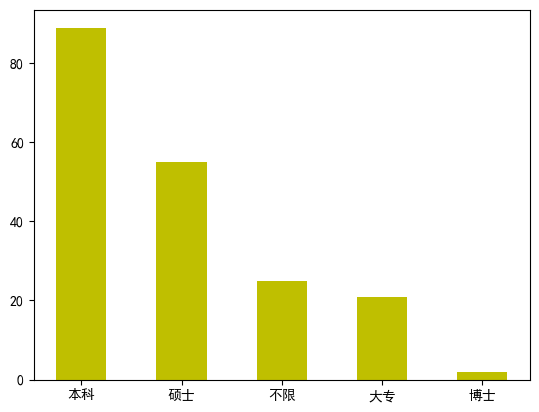

本科    89
硕士    55
不限    25
大专    21
博士     2
Name: 学历, dtype: int64
120.0    84
150.0    52
100.0    22
180.0    11
200.0     6
300.0     3
400.0     3
250.0     1
140.0     1
170.0     1
Name: minmoney, dtype: int64


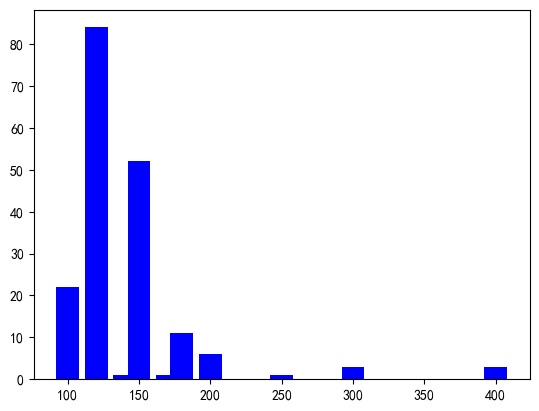

5    148
4     23
3     10
6      9
2      1
1      1
Name: job_week, dtype: int64


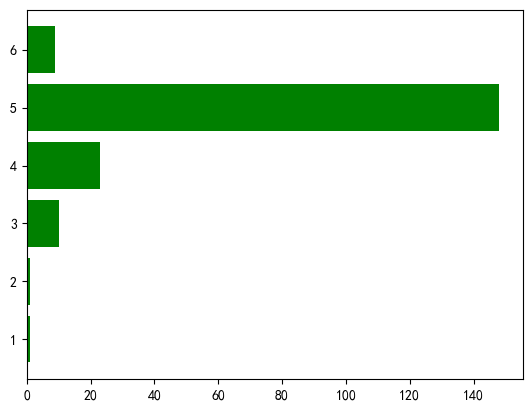

3     62
6     51
2     51
12    15
7      5
1      3
4      2
9      1
8      1
5      1
Name: job_time, dtype: int64


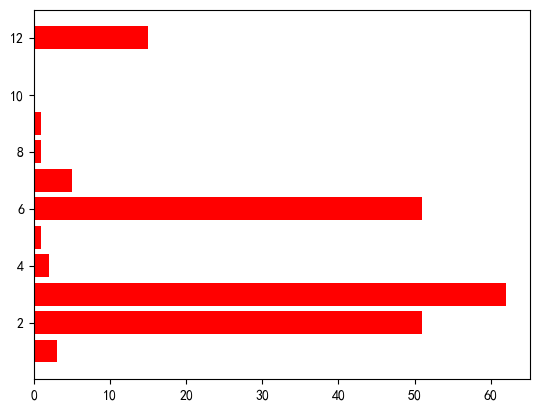

In [142]:
#绘制工作薪酬和工作时间的频率图
import pandas as pd 
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
job = pd.read_csv('job.csv') 
job.info()
a=job.describe() 
print(a)
xueli = job.学历.value_counts()  
plt.bar(xueli.index,xueli.values,color = 'y',width=0.5)
plt.show()
print(xueli)
minmoney1 = job.minmoney.value_counts()  
print(minmoney1)
plt.bar(minmoney1.index,minmoney1.values,color = 'b',width=16)
plt.show()
week = job.job_week.value_counts()  
print(week)
plt.barh(week.index,week.values,color = 'g')
plt.show()
time = job.job_time.value_counts()  
print(time)
plt.barh(time.index,time.values,color = 'r')
plt.show()


In [6]:
#方法2：关于公司的详细信息无法通过beautifulsoup爬取，用selenium爬取具体信息进行分析，并存入sql表格中
import requests
import random
from lxml import etree
import time
import re
import pymysql
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys 
from openpyxl import Workbook

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')

driver = webdriver.Chrome(options=chrome_options)

pomes = []   


def jiexi(url):
    global pomes
    driver.get(url)
    #选择详情网址中的公司详细信息板块
    all_div=driver.find_elements(By.XPATH,'//*[@id="__layout"]/div/div[2]/div[1]/div[2]/div[2]/div[2]')   
    for item in all_div:
        try:
            company_attribute =  item.find_element(By.XPATH,'//*[@id="__layout"]/div/div[2]/div[1]/div[2]/div[2]/div[2]/div[2]/div[3]/div[1]').text      #所属行业 
            company_type = item.find_element(By.XPATH,'//*[@id="__layout"]/div/div[2]/div[1]/div[2]/div[2]/div[2]/div[2]/div[3]/div[2]').text       #企业属性
            company_size = item.find_element(By.XPATH,'//*[@id="__layout"]/div/div[2]/div[1]/div[2]/div[2]/div[2]/div[2]/div[3]/div[3]').text      #公司规模
            #储存在列表中
            value=[]
            value.append(url)
            value.append(company_attribute)
            value.append(company_type)
            value.append(company_size)
                
            print(value)
            pomes.append(value)
        except:
            continue

def shixi(url):
    headers = {"user-agent":"Mozilla/5.0"}
    response=requests.get(url,headers=headers)
    content = response.content.decode('utf8')
    # 解析html字符串
    html = etree.HTML(content)
    detail_urls=html.xpath('//div[contains(@class,"f-l intern-detail__job")]//a/@href') #获取详情页url 
    for detail_url in detail_urls:
        #print(detail_url)
        jiexi(detail_url)  #循环去解析返回的职位详情页
        time.sleep(random.uniform(1, 3)) #随机暂停    

    
def main():
    for x in range(1,11):
        url='https://www.shixiseng.com/interns?page={}&type=intern&keyword=%E4%BF%A1%E6%81%AF%E7%AE%A1%E7%90%86%E4%B8%8E%E4%BF%A1%E6%81%AF%E7%B3%BB%E7%BB%9F&area=&months=&days=&degree=&official=&enterprise=&salary=-0&publishTime=&sortType=&city=%E5%85%A8%E5%9B%BD&internExtend='.format(x)
        shixi(url)
    i=1
    while i < len(pomes)+1:
        for item in pomes:
            item.insert(0,i)
            i +=1
    for item in pomes:
        if bool(re.search(r'\d', item[3]))==True:
            item[4]=item[3]
            item[3]='未知'
    print(pomes)
    #储存在sql表格中
    conn = pymysql.connect(host='localhost',user='root',passwd='sqlZYQaiSR1102',db='spiders',charset='utf8mb4')
    cursor= conn.cursor()
    #新建表
    cursor.execute('CREATE TABLE shixiseng_(id INT,url VARCHAR(255), company_attribute VARCHAR(255),company_type VARCHAR(255),company_size VARCHAR(255),created TIMESTAMP DEFAULT CURRENT_TIMESTAMP, PRIMARY KEY(id));')
    for item in pomes:
        id = item[0]
        url = item[1]
        company_attribute = item[2]
        company_type = item[3] 
        company_size = item[4]
        # 执行插入操作
        sql = 'INSERT INTO shixiseng_(id, url,company_attribute,company_type,company_size) value(%s,%s, %s, %s, %s)'
        cursor.execute(sql, (id,url,company_attribute,company_type,company_size))
    cursor.execute('SELECT * FROM shixiseng_')
    print(cursor.fetchall())
    conn.commit()
    cursor.close()
    conn.close()
    

    #再存入excel文件
    workbook = Workbook()
    save_file = "shixiseng_.xlsx"
    worksheet = workbook.active
    #每个workbook创建后，默认会存在一个worksheet，对默认的worksheet进行重命名
    worksheet.title = "Sheet1"
    for row in pomes:
        worksheet.append(row) # 把每一行append到worksheet中
    workbook.save(filename=save_file) 
    
if __name__ == '__main__':
    main()

['https://www.shixiseng.com/intern/inn_o0z0inwvutmt?pcm=pc_SearchList', '医疗/健康/制药/生物', '国有企业', '50-150人']
['https://www.shixiseng.com/intern/inn_lmrcrqvqn1hn?pcm=pc_SearchList', '金融/经济/投资/财会', '外资企业', '500-2000人']
['https://www.shixiseng.com/intern/inn_f16px2fflfgd?pcm=pc_SearchList', '医疗/健康/制药/生物', '民营企业', '150-500人']
['https://www.shixiseng.com/intern/inn_5qshnypxphx6?pcm=pc_SearchList', '广告/传媒/公关/展览', '外资企业', '2000人以上']
['https://www.shixiseng.com/intern/inn_yktcgydmpqqb?pcm=pc_SearchList', '金融/经济/投资/财会', '外资企业', '2000人以上']
['https://www.shixiseng.com/intern/inn_rahjqbummuie?pcm=pc_SearchList', '汽车/机械/制造', '外资企业', '150-500人']
['https://www.shixiseng.com/intern/inn_ictan0yq3std?pcm=pc_SearchList', '互联网/游戏/软件', '2000人以上', '上海']
['https://www.shixiseng.com/intern/inn_4f2cihe6znxh?pcm=pc_SearchList', '房产/家居/物业/建筑', '国有企业', '150-500人']
['https://www.shixiseng.com/intern/inn_c4yby2qdx60t?pcm=pc_SearchList', '电子/通信/硬件', '事业单位', '2000人以上']
['https://www.shixiseng.com/intern/inn_wgdgwfifocte

['https://www.shixiseng.com/intern/inn_gotsiptkwv0d?pcm=pc_SearchList', '互联网/游戏/软件', '2000人以上', '上海']
['https://www.shixiseng.com/intern/inn_u4f4hzsaqnqh?pcm=pc_SearchList', '教育/培训', '社会团体', '15人以下']
['https://www.shixiseng.com/intern/inn_qlchd8mab0tg?pcm=pc_SearchList', '互联网/游戏/软件', '2000人以上', '上海']
['https://www.shixiseng.com/intern/inn_1pqgrzmhljwh?pcm=pc_SearchList', '房产/家居/物业/建筑', '国有企业', '150-500人']
['https://www.shixiseng.com/intern/inn_bynenuwgprps?pcm=pc_SearchList', '互联网/游戏/软件', '股份制企业', '150-500人']
['https://www.shixiseng.com/intern/inn_b2mijdch0xql?pcm=pc_SearchList', '教育/培训', '民营企业', '少于15人']
['https://www.shixiseng.com/intern/inn_1f5ur6dbnjjo?pcm=pc_SearchList', '互联网/游戏/软件', '股份制企业', '150-500人']
['https://www.shixiseng.com/intern/inn_qdkiiai44cn1?pcm=pc_SearchList', '互联网/游戏/软件', '民营企业', '150-500人']
['https://www.shixiseng.com/intern/inn_x4vnxw44bwcu?pcm=pc_SearchList', '互联网/游戏/软件', '民营企业', '150-500人']
['https://www.shixiseng.com/intern/inn_r1klmhlsbt2r?pcm=pc_SearchList',

['https://www.shixiseng.com/intern/inn_adsyp1ibi51j?pcm=pc_SearchList', '电子/通信/硬件', '事业单位', '2000人以上']
['https://www.shixiseng.com/intern/inn_8zq6omvfc3ke?pcm=pc_SearchList', '电子/通信/硬件', '事业单位', '2000人以上']
['https://www.shixiseng.com/intern/inn_xhnzlovpbo83?pcm=pc_SearchList', '教育/培训', '民营企业', '15-50人']
['https://www.shixiseng.com/intern/inn_gachqjmjnw58?pcm=pc_SearchList', '企业服务/咨询', '民营企业', '15-50人']
['https://www.shixiseng.com/intern/inn_6h5ie2dz7rkf?pcm=pc_SearchList', '企业服务/咨询', '民营企业', '15-50人']
['https://www.shixiseng.com/intern/inn_mmwn23lgaceu?pcm=pc_SearchList', '企业服务/咨询', '民营企业', '15-50人']
['https://www.shixiseng.com/intern/inn_huo4e55fwpdy?pcm=pc_SearchList', '电子/通信/硬件', '事业单位', '2000人以上']
['https://www.shixiseng.com/intern/inn_gpykww9k4f5p?pcm=pc_SearchList', '公共事业/NGO/政府', '事业单位', '150-500人']
['https://www.shixiseng.com/intern/inn_bratqp9jlfvv?pcm=pc_SearchList', '电子/通信/硬件', '事业单位', '2000人以上']
['https://www.shixiseng.com/intern/inn_z9mqevrau7du?pcm=pc_SearchList', '电子/通信/

((1, 'https://www.shixiseng.com/intern/inn_o0z0inwvutmt?pcm=pc_SearchList', '医疗/健康/制药/生物', '国有企业', '50-150人', datetime.datetime(2023, 6, 10, 11, 11, 47)), (2, 'https://www.shixiseng.com/intern/inn_lmrcrqvqn1hn?pcm=pc_SearchList', '金融/经济/投资/财会', '外资企业', '500-2000人', datetime.datetime(2023, 6, 10, 11, 11, 47)), (3, 'https://www.shixiseng.com/intern/inn_f16px2fflfgd?pcm=pc_SearchList', '医疗/健康/制药/生物', '民营企业', '150-500人', datetime.datetime(2023, 6, 10, 11, 11, 47)), (4, 'https://www.shixiseng.com/intern/inn_5qshnypxphx6?pcm=pc_SearchList', '广告/传媒/公关/展览', '外资企业', '2000人以上', datetime.datetime(2023, 6, 10, 11, 11, 47)), (5, 'https://www.shixiseng.com/intern/inn_yktcgydmpqqb?pcm=pc_SearchList', '金融/经济/投资/财会', '外资企业', '2000人以上', datetime.datetime(2023, 6, 10, 11, 11, 47)), (6, 'https://www.shixiseng.com/intern/inn_rahjqbummuie?pcm=pc_SearchList', '汽车/机械/制造', '外资企业', '150-500人', datetime.datetime(2023, 6, 10, 11, 11, 47)), (7, 'https://www.shixiseng.com/intern/inn_ictan0yq3std?pcm=pc_SearchList',